TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0
Extracting ../mnist_data/train-images-idx3-ubyte.gz
Extracting ../mnist_data/train-labels-idx1-ubyte.gz
Extracting ../mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../mnist_data/t10k-labels-idx1-ubyte.gz


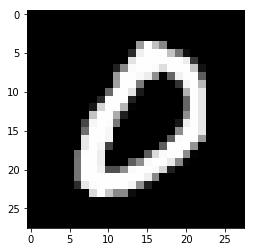

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Helper to make the output consistent
SEED = 42
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check TensorFlow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

# import dataset (should already be present)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../mnist_data', validation_size=0)


# ------ Make sure we're up and running
# display, random, single image
img = mnist.train.images[np.random.randint(6000, size=1)]

# mnist is 28x28 = 784 and is grayscale
# meaning, the 784 vector needs to be reshaped to 28,28
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [3]:
encoding_dim = 64
learning_rate = 0.001
img_vect_size = mnist.train.images.shape[1]

# input place holders
input_vector = tf.placeholder(tf.float32, (None, img_vect_size), name="input_vector")
vect_reshape = tf.reshape(input_vector, [-1, 28, 28, 1])
input_target = tf.placeholder(tf.float32, (None, img_vect_size), name="input_label")
target_reshape = tf.reshape(input_target, [-1, 28, 28, 1])

# --- Model
### Encoder
conv2 = tf.layers.conv2d(inputs=vect_reshape, filters=16, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 14x14x16

encoded = tf.layers.conv2d(inputs=conv2, filters=32, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 7x7x32

dconv1 = tf.layers.conv2d_transpose(inputs=encoded, filters=16, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=tf.nn.elu)
# Now 14x14x64

logits = tf.layers.conv2d_transpose(inputs=dconv1, filters=1, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=None)

#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

# loss
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_reshape, logits=logits)
batch_loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
training_op = optimizer.minimize(batch_loss)

# initializer and saver
with tf.name_scope("save_session"):
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    saver = tf.train.Saver()
    
print("ready")

ready


In [4]:
epochs = 16
batch_size = 256
train_size = mnist.train.num_examples

with tf.Session() as sess:
    init_global.run()
    init_local.run()
    for e in range(epochs):
        for i in range(train_size//batch_size):
            batch_cur = mnist.train.next_batch(batch_size)
            feed_dict = {input_vector: batch_cur[0], input_target: batch_cur[0]}
            cost_batch, _ = sess.run([batch_loss, training_op], feed_dict=feed_dict)
            if i == 0:
                print("E: {}/{} - loss: {:.4f}".format(e+1, epochs, cost_batch))
    save_path = saver.save(sess, "./saver/cnn_autoencoder")

E: 1/16 - loss: 0.6932
E: 2/16 - loss: 0.0824
E: 3/16 - loss: 0.0721
E: 4/16 - loss: 0.0678
E: 5/16 - loss: 0.0661
E: 6/16 - loss: 0.0657
E: 7/16 - loss: 0.0630
E: 8/16 - loss: 0.0630
E: 9/16 - loss: 0.0635
E: 10/16 - loss: 0.0632
E: 11/16 - loss: 0.0630
E: 12/16 - loss: 0.0617
E: 13/16 - loss: 0.0626
E: 14/16 - loss: 0.0640
E: 15/16 - loss: 0.0617
E: 16/16 - loss: 0.0630


INFO:tensorflow:Restoring parameters from ./saver/cnn_autoencoder


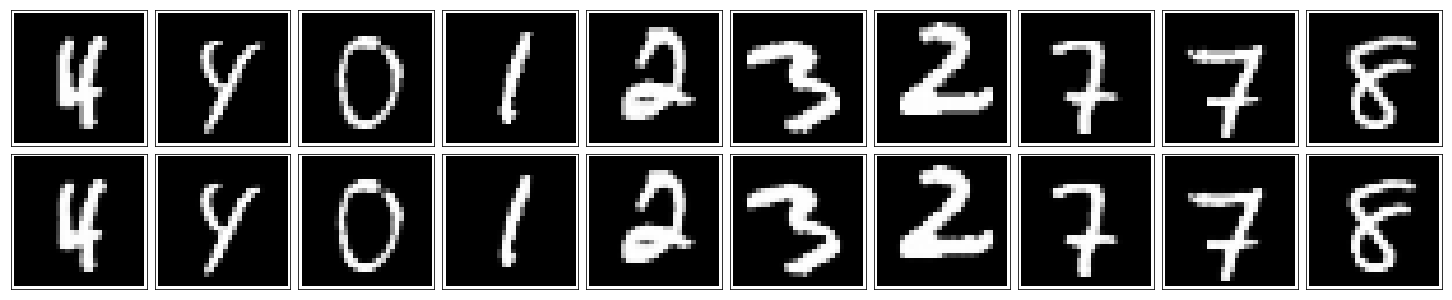

In [5]:
save_path = "./saver/cnn_autoencoder"
sess = tf.Session()
saver.restore(sess, save_path)

start_index = int(np.random.randint(6000, size=1) - 10)
in_imgs = mnist.test.images[start_index:start_index+10]

# run model
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={input_vector: in_imgs})

# plot
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

But the problem here is that our encoded value is 7x7x32 = 1568 values and our regular data is 28x28x1 = 784 values

In [6]:
reset_graph()

In [7]:
encoding_dim = 64
learning_rate = 0.001
img_vect_size = mnist.train.images.shape[1]

# input place holders
input_vector = tf.placeholder(tf.float32, (None, img_vect_size), name="input_vector")
vect_reshape = tf.reshape(input_vector, [-1, 28, 28, 1])
input_target = tf.placeholder(tf.float32, (None, img_vect_size), name="input_label")
target_reshape = tf.reshape(input_target, [-1, 28, 28, 1])

# --- Model
### Encoder
conv2 = tf.layers.conv2d(inputs=vect_reshape, filters=8, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 14x14x16

encoded = tf.layers.conv2d(inputs=conv2, filters=16, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 7x7x32

dconv1 = tf.layers.conv2d_transpose(inputs=encoded, filters=8, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=tf.nn.elu)
# Now 14x14x64

logits = tf.layers.conv2d_transpose(inputs=dconv1, filters=1, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=None)

#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

# loss
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_reshape, logits=logits)
batch_loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
training_op = optimizer.minimize(batch_loss)

# initializer and saver
with tf.name_scope("save_session"):
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    saver = tf.train.Saver()
    
print("ready")

ready


In [8]:
epochs = 10
batch_size = 256
train_size = mnist.train.num_examples

with tf.Session() as sess:
    init_global.run()
    init_local.run()
    for e in range(epochs):
        for i in range(train_size//batch_size):
            batch_cur = mnist.train.next_batch(batch_size)
            feed_dict = {input_vector: batch_cur[0], input_target: batch_cur[0]}
            cost_batch, _ = sess.run([batch_loss, training_op], feed_dict=feed_dict)
            if i == 0:
                print("E: {}/{} - loss: {:.4f}".format(e+1, epochs, cost_batch))
    save_path = saver.save(sess, "./saver/cnn_autoencoder")

E: 1/10 - loss: 0.6926
E: 2/10 - loss: 0.0925
E: 3/10 - loss: 0.0763
E: 4/10 - loss: 0.0723
E: 5/10 - loss: 0.0678
E: 6/10 - loss: 0.0686
E: 7/10 - loss: 0.0674
E: 8/10 - loss: 0.0663
E: 9/10 - loss: 0.0637
E: 10/10 - loss: 0.0644


INFO:tensorflow:Restoring parameters from ./saver/cnn_autoencoder


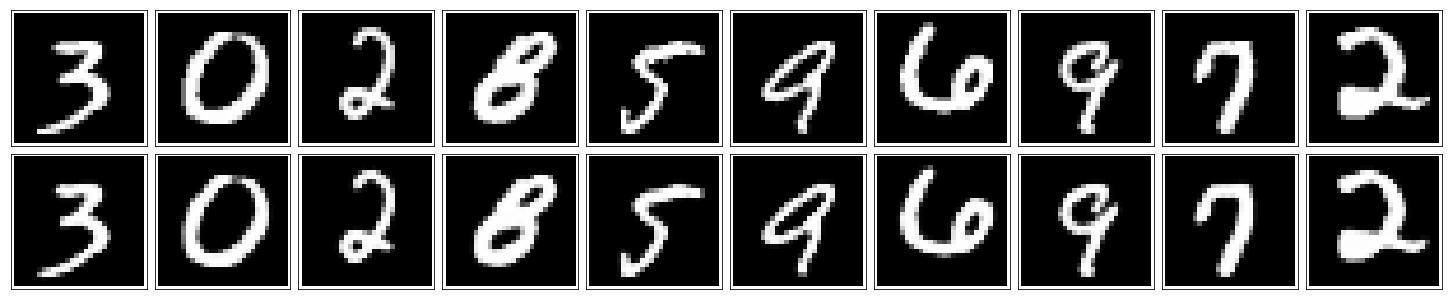

In [9]:
save_path = "./saver/cnn_autoencoder"
sess = tf.Session()
saver.restore(sess, save_path)

start_index = int(np.random.randint(6000, size=1) - 10)
in_imgs = mnist.test.images[start_index:start_index+10]

# run model
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={input_vector: in_imgs})

# plot
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

Pretty good - but we're down to the same number of vaolues now... soooo why even go through the autoencoder?  Let't press further

In [15]:
reset_graph()
learning_rate = 0.001
img_vect_size = mnist.train.images.shape[1]

# input place holders
input_vector = tf.placeholder(tf.float32, (None, img_vect_size), name="input_vector")
vect_reshape = tf.reshape(input_vector, [-1, 28, 28, 1])
input_target = tf.placeholder(tf.float32, (None, img_vect_size), name="input_label")
target_reshape = tf.reshape(input_target, [-1, 28, 28, 1])

# --- Model
### Encoder
conv2 = tf.layers.conv2d(inputs=vect_reshape, filters=4, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 14x14x4

encoded = tf.layers.conv2d(inputs=conv2, filters=8, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 7x7x8

dconv1 = tf.layers.conv2d_transpose(inputs=encoded, filters=4, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=tf.nn.elu)
# Now 14x14x4

logits = tf.layers.conv2d_transpose(inputs=dconv1, filters=1, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=None)

#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

# loss
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_reshape, logits=logits)
batch_loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
training_op = optimizer.minimize(batch_loss)

# initializer and saver
with tf.name_scope("save_session"):
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    saver = tf.train.Saver()
    
print("ready")

ready


In [16]:
epochs = 10
batch_size = 256
train_size = mnist.train.num_examples

with tf.Session() as sess:
    init_global.run()
    init_local.run()
    for e in range(epochs):
        for i in range(train_size//batch_size):
            batch_cur = mnist.train.next_batch(batch_size)
            feed_dict = {input_vector: batch_cur[0], input_target: batch_cur[0]}
            cost_batch, _ = sess.run([batch_loss, training_op], feed_dict=feed_dict)
            if i == 0:
                print("E: {}/{} - loss: {:.4f}".format(e+1, epochs, cost_batch))
    save_path = saver.save(sess, "./saver/cnn_autoencoder")

E: 1/10 - loss: 0.6934
E: 2/10 - loss: 0.1538
E: 3/10 - loss: 0.1023
E: 4/10 - loss: 0.0913
E: 5/10 - loss: 0.0810
E: 6/10 - loss: 0.0768
E: 7/10 - loss: 0.0777
E: 8/10 - loss: 0.0745
E: 9/10 - loss: 0.0734
E: 10/10 - loss: 0.0712


INFO:tensorflow:Restoring parameters from ./saver/cnn_autoencoder


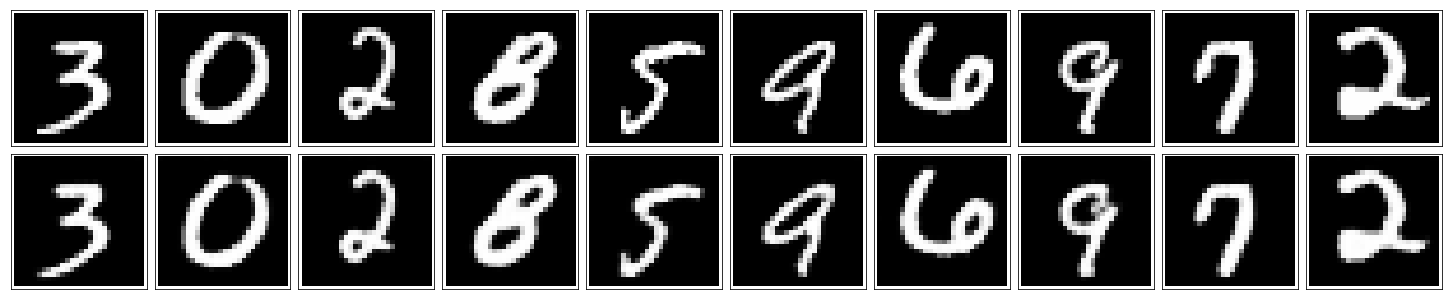

In [17]:
save_path = "./saver/cnn_autoencoder"
sess = tf.Session()
saver.restore(sess, save_path)

start_index = int(np.random.randint(6000, size=1) - 10)
in_imgs = mnist.test.images[start_index:start_index+10]

# run model
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={input_vector: in_imgs})

# plot
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

In [18]:
reset_graph()
learning_rate = 0.001
img_vect_size = mnist.train.images.shape[1]

# input place holders
input_vector = tf.placeholder(tf.float32, (None, img_vect_size), name="input_vector")
vect_reshape = tf.reshape(input_vector, [-1, 28, 28, 1])
input_target = tf.placeholder(tf.float32, (None, img_vect_size), name="input_label")
target_reshape = tf.reshape(input_target, [-1, 28, 28, 1])

# --- Model
### Encoder
conv2 = tf.layers.conv2d(inputs=vect_reshape, filters=2, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 14x14x2

encoded = tf.layers.conv2d(inputs=conv2, filters=4, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 7x7x4

dconv1 = tf.layers.conv2d_transpose(inputs=encoded, filters=2, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=tf.nn.elu)
# Now 14x14x2

logits = tf.layers.conv2d_transpose(inputs=dconv1, filters=1, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=None)

#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

# loss
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_reshape, logits=logits)
batch_loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
training_op = optimizer.minimize(batch_loss)

# initializer and saver
with tf.name_scope("save_session"):
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    saver = tf.train.Saver()
    
print("ready")

ready


In [19]:
epochs = 20
batch_size = 256
train_size = mnist.train.num_examples

with tf.Session() as sess:
    init_global.run()
    init_local.run()
    for e in range(epochs):
        for i in range(train_size//batch_size):
            batch_cur = mnist.train.next_batch(batch_size)
            feed_dict = {input_vector: batch_cur[0], input_target: batch_cur[0]}
            cost_batch, _ = sess.run([batch_loss, training_op], feed_dict=feed_dict)
            if i == 0:
                print("E: {}/{} - loss: {:.4f}".format(e+1, epochs, cost_batch))
    save_path = saver.save(sess, "./saver/cnn_autoencoder")

E: 1/20 - loss: 0.6942
E: 2/20 - loss: 0.2538
E: 3/20 - loss: 0.1755
E: 4/20 - loss: 0.1532
E: 5/20 - loss: 0.1377
E: 6/20 - loss: 0.1239
E: 7/20 - loss: 0.1141
E: 8/20 - loss: 0.1099
E: 9/20 - loss: 0.1057
E: 10/20 - loss: 0.1003
E: 11/20 - loss: 0.0944
E: 12/20 - loss: 0.0922
E: 13/20 - loss: 0.0890
E: 14/20 - loss: 0.0870
E: 15/20 - loss: 0.0822
E: 16/20 - loss: 0.0797
E: 17/20 - loss: 0.0779
E: 18/20 - loss: 0.0786
E: 19/20 - loss: 0.0779
E: 20/20 - loss: 0.0764


INFO:tensorflow:Restoring parameters from ./saver/cnn_autoencoder


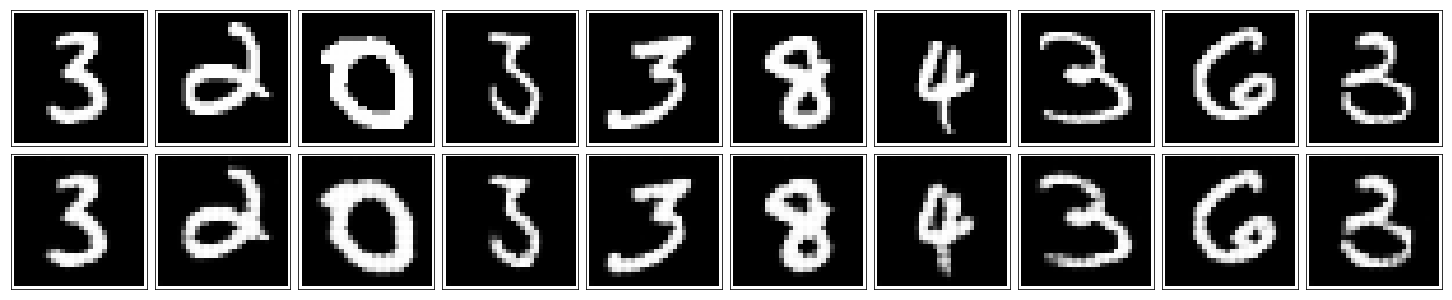

In [20]:
save_path = "./saver/cnn_autoencoder"
sess = tf.Session()
saver.restore(sess, save_path)

start_index = int(np.random.randint(6000, size=1) - 10)
in_imgs = mnist.test.images[start_index:start_index+10]

# run model
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={input_vector: in_imgs})

# plot
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

Pretty good!  Our values are now `7x7x4=196` vs `28x28=784`

In [26]:
reset_graph()
learning_rate = 0.001
img_vect_size = mnist.train.images.shape[1]

# input place holders
input_vector = tf.placeholder(tf.float32, (None, img_vect_size), name="input_vector")
vect_reshape = tf.reshape(input_vector, [-1, 28, 28, 1])
input_target = tf.placeholder(tf.float32, (None, img_vect_size), name="input_label")
target_reshape = tf.reshape(input_target, [-1, 28, 28, 1])

# --- Model
### Encoder
conv0 = tf.layers.conv2d(inputs=vect_reshape, filters=32, 
                         kernel_size=(3,3), strides=1, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)


conv1 = tf.layers.conv2d(inputs=conv0, filters=16, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 14x14x16

conv2 = tf.layers.conv2d(inputs=conv1, filters=8, 
                         kernel_size=(3,3), strides=1, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)

conv3 = tf.layers.conv2d(inputs=conv2, filters=4, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 7x7x4

encoded = tf.layers.conv2d(inputs=conv3, filters=1, 
                         kernel_size=(3,3), strides=1, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 7x7x1

dconv1 = tf.layers.conv2d_transpose(inputs=encoded, filters=4, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=tf.nn.elu)
# Now 14x14x4

dconv2 = tf.layers.conv2d_transpose(inputs=dconv1, filters=4, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=tf.nn.elu)
# Now 28x28x4

logits = tf.layers.conv2d_transpose(inputs=dconv2, filters=1, 
                                    kernel_size=(3,3), strides=1, 
                                    padding="same", activation=None)

#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

# loss
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_reshape, logits=logits)
batch_loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
training_op = optimizer.minimize(batch_loss)

# initializer and saver
with tf.name_scope("save_session"):
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    saver = tf.train.Saver()
    
print("ready")

ready


In [27]:
epochs = 20
batch_size = 256
train_size = mnist.train.num_examples

with tf.Session() as sess:
    init_global.run()
    init_local.run()
    for e in range(epochs):
        for i in range(train_size//batch_size):
            batch_cur = mnist.train.next_batch(batch_size)
            feed_dict = {input_vector: batch_cur[0], input_target: batch_cur[0]}
            cost_batch, _ = sess.run([batch_loss, training_op], feed_dict=feed_dict)
            if i == 0:
                print("E: {}/{} - loss: {:.4f}".format(e+1, epochs, cost_batch))
    save_path = saver.save(sess, "./saver/cnn_autoencoder")

E: 1/20 - loss: 0.6932
E: 2/20 - loss: 0.4054
E: 3/20 - loss: 0.3888
E: 4/20 - loss: 0.3442
E: 5/20 - loss: 0.1326
E: 6/20 - loss: 0.1096
E: 7/20 - loss: 0.1119
E: 8/20 - loss: 0.1087
E: 9/20 - loss: 0.0998
E: 10/20 - loss: 0.1045
E: 11/20 - loss: 0.1012
E: 12/20 - loss: 0.1014
E: 13/20 - loss: 0.1010
E: 14/20 - loss: 0.1004
E: 15/20 - loss: 0.1032
E: 16/20 - loss: 0.0984
E: 17/20 - loss: 0.0999
E: 18/20 - loss: 0.1015
E: 19/20 - loss: 0.0966
E: 20/20 - loss: 0.0980


INFO:tensorflow:Restoring parameters from ./saver/cnn_autoencoder


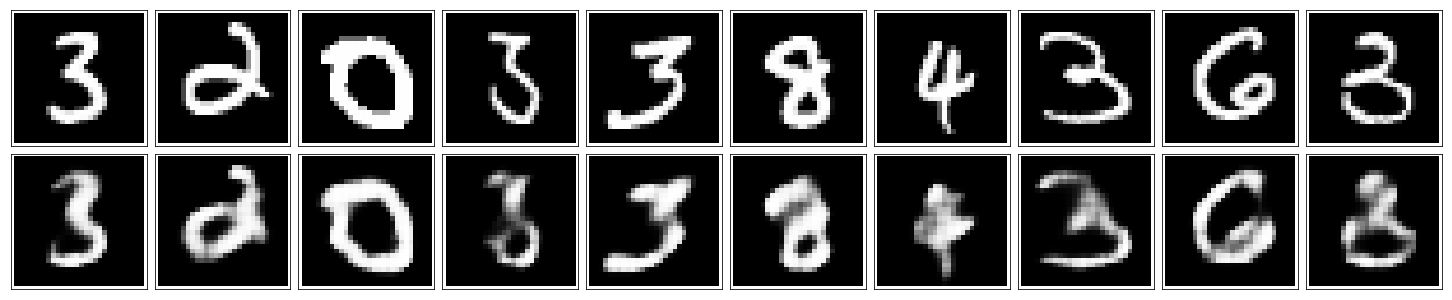

In [28]:
save_path = "./saver/cnn_autoencoder"
sess = tf.Session()
saver.restore(sess, save_path)

start_index = int(np.random.randint(6000, size=1) - 10)
in_imgs = mnist.test.images[start_index:start_index+10]

# run model
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={input_vector: in_imgs})

# plot
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

In [29]:
print(compressed.shape)

(10, 7, 7, 1)


In [5]:
sess.close()